# Machine Learning Demonstrations

In this notebook, we demonstrated how to use the Kx kdb+/q Automated Machine Learning library. The example below use samples from the Telco Customer Churn dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Machine Learning Toolkit

The Machine Learning Toolkit ([ML-Toolkit](https://github.com/KxSystems/ml)) contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm and cross validation functions. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

## Automated Machine Learning in kdb+/q

The kdb+/q [Automated Machine Learning](https://github.com/kxsystems/automl/) library is built largely on the tools available within the kdb+/q ML-Toolkit. The purpose of this library is to provide users with the ability to automate the process of applying machine learning techniques to real-world problems. In the absence of expert machine learning engineers this framework handles the following processes within a traditional workflow:

- Data preprocessing
- Feature engineering and feature selection
- Model selection
- Hyperparameter Tuning
- Report generation and model persistence

Each of these steps is outlined in depth within the documentation for this platform [here](https://code.kx.com/ml/automl). This allows users to understand the processes by which decisions are being made and the transformations which their data undergo during the production of the output models.

At present the supported machine learning problem types are classification and regression and based on:

- One-to-one feature to target non time-series
- FRESH based feature extraction and model production

The problems which can be solved by this framework will be expanded over time as will the available functionality.

### Multi-processing

This library supports multi-processed grid-search/cross-validation procedures and FRESH feature creation provided a user set `-s -8` in the JUPYTERQ_SERVERARGS, access to which can be found [here](https://code.kx.com/q/ml/jupyterq/notebooks/#server-command-line-arguments). In this demo, we use 8 worker processes and open a centralised port as below.

In [1]:
\p 5124

The Kx Automated Machine Learning library is then loaded in as follows:

In [2]:
// load in automl
\l automl_kx/automl.q
.automl.loadfile`:init.q

Requirements for deep learning models not available, these will not be run


---

## Telco Customer Churn

The [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn/data) contains entries for 7043 customers. In each case below, we aim to create a model which can accurately predict customer churn based on 20 features relating to each customer.

Below we load in the data and select a subset of 5000 random data points to train and test the pipeline on. We also load in additional graphics and utility functions required throughout this notebook.

### Load data

In [3]:
// load utils
\l ../utils/util.q
\l ../utils/graphics.q

In [4]:
\S 42

// load data and separate into features and target
data:5000?("SSBSSISSSSSSSSSSSSFFS";(),",")0:`:../data/telco.csv
targ:(`No`Yes!0 1)data`Churn
feat:delete Churn from data

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape feat),"\n";
show 5#feat
-1"\nDistribution of target values:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:targ);

Shape of feature data is: 5000 x 20

customerID gender SeniorCitizen Partner Dependents tenure PhoneService Multip..
-----------------------------------------------------------------------------..
5382-TEMLV Male   0             No      No         45     Yes          No    ..
5827-MWCZK Male   0             Yes     Yes        56     Yes          Yes   ..
3086-RUCRN Female 0             No      No         66     Yes          Yes   ..
5965-GGPRW Male   0             Yes     Yes        72     Yes          Yes   ..
2887-JPYLU Female 0             No      Yes        41     Yes          No    ..

Distribution of target values:

target| num  pcnt 
------| ----------
0     | 3637 72.74
1     | 1363 27.26


### User Interface

At the highest level the automated machine learning library contains two primary callable functions:

- `.automl.run` = Run the automated machine learning pipeline on user defined data and target
- `.automl.new` = Using a previously fit model and set of instructions to produce an appropriate pipeline derived from a defined run, predict the target value for new tabular data

Both of these functions are modifiable by a user to suit specific use cases and have been designed to cover a wide range of functional options and to be extensible to a users needs.

### Prepare data

As we want to run both `.automl.run` and `.automl.new` we start by splitting our data into a training and testing set, where 10% has been chosen for the testing set. Note that we have set a random seed so that results can be replicated.

In [5]:
\S 42
show inputs:.ml.traintestsplit[feat;targ;.1]

xtrain| +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytrain| 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0..
xtest | +`customerID`gender`SeniorCitizen`Partner`Dependents`tenure`PhoneServ..
ytest | 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0..


---

## Contents

Below, the notebook has been split into 2 distinct sections:
1. [Default Configurations](#Default-Configurations)
2. [Custom Configurations (Advanced)](#Custom-Configurations-(Advanced))

---

## Default Configurations

### Inputs

Below we demonstrate how to apply `.automl.run` to our features and targets in the default setting, where the function has the syntax:

```.automl.run[tab;tgt;ftype;ptype;dict]```

Where:
- `tab` is unkeyed tabular data from which the models will be created
- `tgt` is the target vector
- `ftype` type of feature extraction being completed on the dataset as a symbol (``` `fresh```/``` `normal```)
- `ptype` type of problem, regression/class, as a symbol (``` `reg```/``` `class```)
- `dict` is one of `(::)` for default behaviour, a kdb+ dictionary or path to a user defined flat file for modifying default parameters.

In this case, we select ``` `normal``` feature extraction as we have a 1-to-1 mapping between features and targets. We also use ``` `class``` for the problem type as we are dealing with a binary classification problem.

**NB:** For the purposes of this demonstration we will pass in a dictionary in place of the default parameter `(::)`. In order to ensure replication for users of this notebook the random seed parameter ``` `seed``` is set in this example with the remaining parameters defaulted.

In [6]:
tab:inputs`xtrain             / features
tgt:inputs`ytrain             / targets
ftype:`normal                 / normal feature extraction
ptype:`class                  / classification problem
dict:enlist[`seed]!enlist 42  / default configuration

### Outputs

In the default configuration, the following items will be returned/saved during an individual run:

- The best model, saved as a hdf5 file for keras models, or "pickled" byte objects for sklearn models.
- A saved report indicating the procedure taken and scores achieved.
- A saved byte encoded dictionary denoting the procedure to be taken for reproducing results or running on new data.
- Results from each step of the pipeline published to console.

In addition to the saved outputs, the function will also return the date and time of the current run. This allows users to run the best model from a defined run on new data by passing the date and time to `.automl.new` (see example [below](#Test-on-new-data)).

We can now run `.aml.run` using the default setting with out training set from the Telco Customer Churn dataset.

In [7]:
start:.z.t
r1:.automl.run[tab;tgt;ftype;ptype;dict]
-1"\n.automl.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      categorical
PhoneService    | 4500  2      ::       ::       ::    ::      categorical
MultipleLines   | 4500  3      ::       ::       ::    ::      categorical
InternetService | 4500  3      ::       ::       ::    ::      categorical
Online

<Figure size 1440x1440 with 0 Axes>

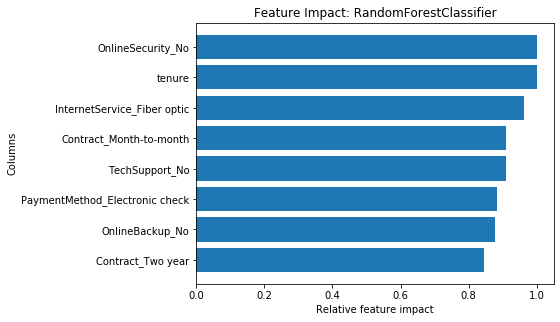

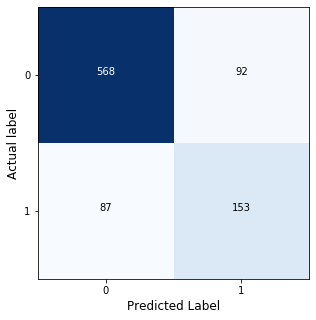

In [8]:
plt[`:show][];

#### Feature impact

We see that in the above example, 8 features were passed to the model following the application of feature extraction and significance testing. 

**NB:** In the default case, normal feature extraction only uses the original features passed into the system, while FRESH feature extraction would apply the functions available for FRESH within the ML-Toolkit as defined by `.ml.fresh.params`.

Looking at the feature impact above, we can see that `tenure` had the highest feature impact in the dataset when applied to the best model.

#### Confusion matrix

A confusion matrix is also produced within the pipeline for classification problems. We see that the final `RandomForestClassifier` model correctly classified 723 data points. 

All other outputs from this run have been stored in a directory of format `/outputs/date/run_time/`

### Test on new data

We can apply the workflow and fitted model associated with our specified run to new data using:

```.automl.new[tab;dt;tm]```

Where:

- `tab` is an unkeyed tabular dataset which has the same schema as the input data from the run specified in fpath
- `dt` is the date for a specified run as a date `yyyy.mm.dd` or a string of format `"yyyy.mm.dd"`
- `tm` is the timestamp for a specified run as a timestamp `hh:mm:ss.xxx` or a string of format `"hh:mm:ss.xxx"` or `"hh.mm.ss.xxx"` 

**NB:** Outputs from previous runs, such as `models` or `config`, are stored in the `outputs` directory and are organised such that we have the following file structure: `outputs/dt/run_tm/`, e.g. `outputs/2001.01.01/run_12.00.00.000"`.

The function will return the target predictions for new data based on the previously fitted model and workflow.

Below we apply `.automl.new` to the test set we created earlier and pass in the date and time of the previous run. This will apply the best model from the run above to our new data:

In [9]:
// What run is being applied to the dataset?
print_runid . r1;
-1"\nPredictions: ";
show pred:.automl.new[inputs`xtest]. r1
-1"\nTargets:";
show inputs`ytest

Run date: 2020.04.21. Run time: 16:53:28.207.

Predictions: 
0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


We can see how the model performed using `.ml.accuracy`, used in the original default pipeline, and by producing a confusion matrix using `displayCM`:

In [10]:
-1"Accuracy on model run using hold-out data: ",string acc1:.ml.accuracy[inputs`ytest;pred];

Accuracy on model run using hold-out data: 0.82


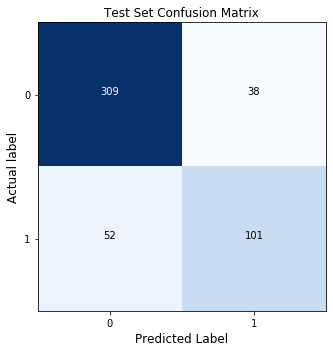

In [11]:
displayCM[value .ml.confmat[inputs`ytest;pred];`0`1;"Test Set Confusion Matrix";()];

---

## Custom Configurations (Advanced)

In the previous section of the notebook, we showcased how to apply default parameters within the pipeline (excluding the random seed). In this section we will focus on how the final parameter of `.automl.run` can be modified to apply changes to the default behaviour.

There are two options for how this final parameter can be input:
- **kdb+ dictionary** outlining the changes to default behaviour that are to be made
- The path to a **flat file** containing more human readable configuration updates.

### Advanced parameters

The following lists the parameters which can be altered by users to modify the functionality of the automl platform. In each case, the parameter name corresponds to the kdb+ dictionary key which would be passed, alongside its user defined value, to the `.automl.run` function in order to update functionality.

Parameters:

```txt
  aggcols     Aggregation columns for FRESH
  funcs       Functions to be applied for feature extraction
  gs          Grid search function and associated no. of folds/percentage
  hld         Size of holdout set on which the final model is tested
  saveopt     Saving options outlining what is to be saved to disk from a run
  scf         Scoring functions for classification/regression tasks
  seed        Random seed to be used
  sigfeats    Feature significance procedure to be applied to the data
  sz          Size of test set for train-test split function
  tts         Train-test split function to be applied
  xv          Cross validation function and associated no. of folds/percentage
```

### Example 1

In this case, we have altered the parameter dictionary `p` in the following ways:
1. Added a **random seed**: Here we have altered the ``` `seed``` parameter to be `75`.
2. Added **feature extraction**: As mentioned above, in the default setting no functions are applied to the table during feature extraction. Below we apply `.automl.prep.i.truncsvd` to the data, this is a truncated singular value decomposition outlined [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) and applied to all combinations of columns of type float.
3. Changed the size of the **testing** and **holdout** sets to be 10% of the data at each stage.

In [12]:
show p:`seed`funcs`sz`hld!(75;`.automl.prep.i.truncsvd;.1;.1)

seed | 75
funcs| `.automl.prep.i.truncsvd
sz   | 0.1
hld  | 0.1


In [13]:
start:.z.t
r2:.automl.run[inputs`xtrain;inputs`ytrain;`normal;`class;p]
-1"\n.automl.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 4500  73     32.326   24.55931 0i    72i     numeric    
MonthlyCharges  | 4500  1251   64.88498 30.49795 18.55 118.75  numeric    
TotalCharges    | 4500  3178   2284.252 2275.078 18.85 8672.45 numeric    
customerID      | 4500  3310   ::       ::       ::    ::      categorical
gender          | 4500  2      ::       ::       ::    ::      categorical
Partner         | 4500  2      ::       ::       ::    ::      categorical
Dependents      | 4500  2      ::       ::       ::    ::      categorical
PhoneService    | 4500  2      ::       ::       ::    ::      categorical
MultipleLines   | 4500  3      ::       ::       ::    ::      categorical
InternetService | 4500  3      ::       ::       ::    ::      categorical
Online

<Figure size 1440x1440 with 0 Axes>

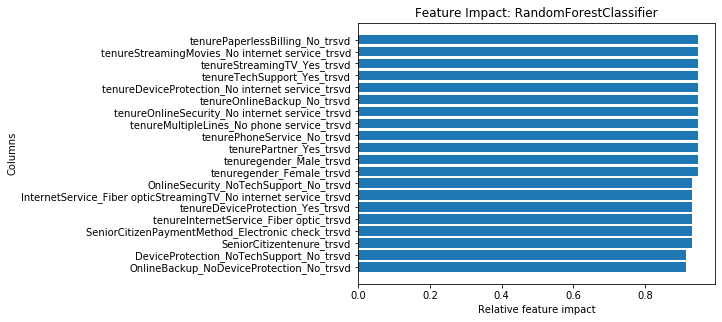

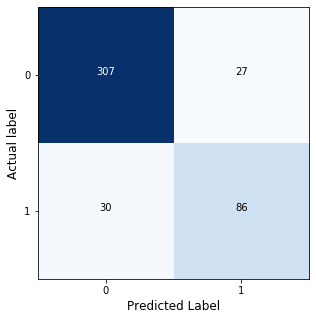

In [14]:
plt[`:show][];

We can see by looking at the feature impact that many of the most impactful features are now derived from those generated when `.automl.prep.i.truncsvd` was applied during feature extraction, this gives some insight into the potential benefit of this form of feature extraction. 

While benefiting from increases in accuracy the addition of larger numbers of features (271 vs 8) can have the effect of slowing training time and scoring time which have have an impact in time critical use-cases.

We can now predict on the hold-out dataset in order to compare accuracy results to the default case.

In [15]:
print_runid . r2;
-1"\nPredictions: ";
show pred:.automl.new[inputs`xtest]. r2
-1"\nTargets:";
show inputs`ytest

Run date: 2020.04.21. Run time: 16:54:24.723.

Predictions: 
0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0..

Targets:
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0..


In [16]:
print_runid . r1;
-1"Accuracy on default model run using held-out data: ",string[acc1],"\n";
print_runid . r2;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[inputs`ytest;pred];

Run date: 2020.04.21. Run time: 16:53:28.207.
Accuracy on default model run using held-out data: 0.82

Run date: 2020.04.21. Run time: 16:54:24.723.
Accuracy on custom model run using held-out data : 0.886


We can see that by adding feature extraction in the normal case we have improved our accuracy by ~ 8%. This is highlighted in the confusion matrix below.

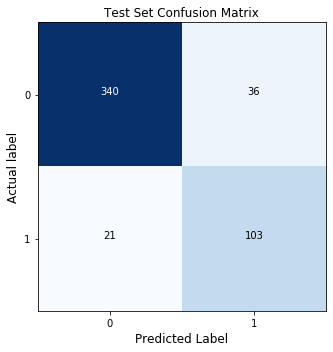

In [17]:
displayCM[value .ml.confmat[inputs`ytest;pred];`0`1;"Test Set Confusion Matrix";()];

### Example 2

In this example we highlight how to change the save options, contained under ``` `saveopt``` within the parameter dictionary.

In the default case, not modified in the examples above, the system will save all outputs to disk (reports, images, config file and models). This can be altered by the user to reduce the number of outputs saved to disk, where:

- `0` = Nothing is saved the models will run and display results to console but nothing persisted
- `1` = Save the model and configuration file only, will not generate a report for the user or any images
- `2` = Save all possible outputs to disk for the user including reports, images, config and models

We demonstrate the case for `0` below for a subset of 1000 data points.

In [18]:
\S 42
feat:1000?feat
targ:1000?targ

In [19]:
.automl.run[feat;targ;`normal;`class;enlist[`saveopt]!enlist 0];


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 1000  73     33.551   25.0546  0i    72i     numeric    
MonthlyCharges  | 1000  582    64.02735 30.38511 18.8  118.75  numeric    
TotalCharges    | 1000  834    2358.61  2345.948 18.85 8672.45 numeric    
customerID      | 1000  842    ::       ::       ::    ::      categorical
gender          | 1000  2      ::       ::       ::    ::      categorical
Partner         | 1000  2      ::       ::       ::    ::      categorical
Dependents      | 1000  2      ::       ::       ::    ::      categorical
PhoneService    | 1000  2      ::       ::       ::    ::      categorical
MultipleLines   | 1000  3      ::       ::       ::    ::      categorical
InternetService | 1000  3      ::       ::       ::    ::      categorical
Online

As we can see compared to the previous default behaviour nothing has been saved down during a single run of the pipeline.

### Example 3

We have shown in the previous examples that the pipeline can be altered by passing in a dictionary of parameters as the last argument in `.automl.run`. As mentioned previously, we can also pass the path to a flat file.

Default flat files are saved to `automl/code/models/` where users can change parameters within each file. These are generated by a user using the function `.automl.savedefault` as follows:

In [20]:
.automl.savedefault["new_normal_defaults.txt";`normal]

We can then run the pipeline using this new file as our final argument:

In [21]:
.automl.run[feat;targ;`normal;`class;"new_normal_defaults.txt"];


The following is a breakdown of information for each of the relevant columns in the dataset

                | count unique mean     std      min   max     type       
------          | --------------------------------------------------------
tenure          | 1000  73     33.551   25.0546  0i    72i     numeric    
MonthlyCharges  | 1000  582    64.02735 30.38511 18.8  118.75  numeric    
TotalCharges    | 1000  834    2358.61  2345.948 18.85 8672.45 numeric    
customerID      | 1000  842    ::       ::       ::    ::      categorical
gender          | 1000  2      ::       ::       ::    ::      categorical
Partner         | 1000  2      ::       ::       ::    ::      categorical
Dependents      | 1000  2      ::       ::       ::    ::      categorical
PhoneService    | 1000  2      ::       ::       ::    ::      categorical
MultipleLines   | 1000  3      ::       ::       ::    ::      categorical
InternetService | 1000  3      ::       ::       ::    ::      categorical
Online

---